In [2]:
import pandas as pd
import glob
import time
import duckdb
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext sql

In [3]:
conn = duckdb.connect("mydb1.db")

<h5>Creating the users table</h5>

In [13]:
df_user = conn.execute("""
  CREATE TABLE users AS SELECT * FROM read_parquet('merged/users_merged.parquet')
""")


In [ ]:
conn.execute(" EXPLAIN users")

<h5>Creating the Transactions table</h5>

In [9]:
df_user = conn.execute("""
  CREATE TABLE transactions AS SELECT * FROM read_parquet('merged/transactions_merged_all.parquet')
""")

In [ ]:
conn.execute(" EXPLAIN transactions")

<h5>Creating the Prodcts table</h5>

In [11]:
df_user = conn.execute("""
  CREATE TABLE products AS SELECT * FROM read_parquet('merged/products_merged.parquet')
""")

In [ ]:
conn.execute(" EXPLAIN products")

<h3> BASIC ANALYSIS ON THE TABLES </h3>

1. To view the first 10 rows of all the given tables

In [18]:
conn.execute(" select * from users LIMIT 10").df()

,user_id,user_name,email,date_of_birth,address,state,country
0,1001,Michael Hamilton,jacquelineperry@example.net,1944-10-27,"9550 Smith Ridges\nCynthiastad, MH 80405",Kansas,Mexico
1,1002,William Stokes,cory68@example.org,1970-02-15,"2849 Amanda Bridge Suite 535\nNorth Scott, ME ...",Utah,United Kingdom
2,1003,Tammy Archer,reyesjohn@example.net,1955-03-01,"43205 Hopkins Brook\nCaseyborough, UT 13233",Tennessee,Lithuania
3,1004,Chelsea Herrera,vsingh@example.org,1959-01-01,"800 Emily Harbor Apt. 727\nJonesmouth, FL 51151",Indiana,Romania
4,1005,Peter Thomas,ebentley@example.org,1999-10-12,Unit 5504 Box 8656\nDPO AA 32630,Alaska,Togo
5,1006,Pamela Nelson,fostermichael@example.net,1990-01-23,"0959 Samuel Junction\nPort Natalie, MH 99949",Louisiana,Cuba
6,1007,Eric Nguyen,jhuber@example.com,1968-02-25,"5937 Schneider Heights\nPort Stephenville, IA ...",Arizona,Russian Federation
7,1008,Kimberly Burke,reyesmelissa@example.net,1995-12-15,"646 Daniels Trail Suite 903\nThomashaven, FL 6...",Nebraska,Swaziland
8,1009,Steven Blake,ronald02@example.org,1990-02-11,"8619 Michael Divide\nFoxstad, CO 16596",Oklahoma,Qatar
9,1010,Mackenzie Fitzgerald,chadmiller@example.net,1964-03-28,"412 Carter Union Apt. 761\nStacymouth, ND 44214",Montana,Belarus


In [19]:
conn.execute(" select * from products LIMIT 10").df()

,product_id,product_name,category,price
0,P689,blood,Clothing,175.56
1,P802,cultural,Accessories,85.98
2,P821,turn,Clothing,115.44
3,P977,notice,Tools,27.76
4,P403,including,Clothing,55.68
5,P322,will,Tools,29.27
6,P221,push,Tools,76.42
7,P728,anyone,Electronics,35.98
8,P469,everything,Tools,153.82
9,P138,tree,Home,147.97


In [20]:
conn.execute(" select * from transactions LIMIT 10").df()

,transaction_id,user_id,product_id,product_name,amount,transaction_date
0,1,1100,P148,job,50.03,2023-04-27 03:57:05
1,2,1195,P937,never,48.00,2023-05-14 22:55:01
2,3,1934,P244,threat,39.08,2023-06-04 21:53:53
3,4,1081,P113,art,96.16,2023-06-14 10:53:56
4,5,1399,P981,foot,35.09,2023-05-13 05:44:19
5,6,1452,P803,center,77.23,2023-06-27 17:31:51
6,7,1559,P938,doctor,18.84,2023-04-25 23:59:38
7,8,1701,P384,also,96.38,2023-02-19 08:58:17
8,9,1024,P918,control,44.15,2023-07-20 16:28:37
9,10,1822,P112,realize,36.15,2023-06-03 11:56:52


2. Count of total number of rows in each Table

In [21]:
conn.execute("  SELECT count(*) AS user_count FROM users  ").df()



,user_count
0,10100000


In [22]:
conn.execute("  SELECT count(*) AS product_count FROM products  ").df()

,product_count
0,300000


In [23]:
conn.execute("  SELECT count(*) AS transaction_count FROM transactions  ").df()

,transaction_count
0,100000000


3. Statestical data on the transaction Tables

In [24]:
conn.execute("""
             
             SELECT MIN(amount) , MAX(amount) , AVG(amount) FROM transactions
             
             
             """).df()

,min(amount),max(amount),avg(amount)
0,10.0,100.0,55.000622


There is no null values in any of the tables as the data was synthetically created so no need to handle any null values

4. Data Cleaning Procedure:
    Check for duplicate values

In [40]:

duplicate_query = "SELECT transaction_id FROM transactions GROUP BY transaction_id HAVING COUNT(*) > 1"
duplicate_result = conn.execute(duplicate_query)

# Fetch the results as a DataFrame
duplicate_result.df()


,transaction_id


In [30]:
conn.execute("SELECT user_id, user_name, email, date_of_birth, address, state, country, COUNT(*) AS count FROM users GROUP BY user_id, user_name, email, date_of_birth, address, state, country HAVING COUNT(*) > 1").df()

,user_id,user_name,email,date_of_birth,address,state,country,count


In [31]:
conn.execute("SELECT product_id, product_name, category, price, COUNT(*) AS count FROM products GROUP BY product_id, product_name, category, price HAVING COUNT(*) > 1").df()

,product_id,product_name,category,price,count
0,P381,guess,Tools,141.11,2
1,P121,ability,Tools,60.61,2
2,P350,agent,Electronics,178.71,2


Now removing the duplicates from the products table

In [41]:
conn.execute("""
    delete from products where "product_id" == 'P381' OR "product_id" == 'P121' OR "product_id" == 'P350'



""")

In [42]:
conn.execute("SELECT product_id, product_name, category, price, COUNT(*) AS count FROM products GROUP BY product_id, product_name, category, price HAVING COUNT(*) > 1").df()

,product_id,product_name,category,price,count


<h3>Performing complex aggregated qeries on the tables </h3>

1. Calculating total revenue by category

In [42]:
cur_time = time.time()
result_query = conn.execute("""
    SELECT p.category, SUM(t.amount) AS total_revenue
    FROM transactions t
    JOIN products p ON t.product_id = p.product_id
    GROUP BY p.category
""")

result_df = result_query.df()

print(f"Execution Time: {(time.time() - cur_time)} seconds")

print(result_df)








Execution Time: 344.5580942630768 seconds
      category  total_revenue
0  Accessories   3.647723e+11
1         Home   3.676285e+11
2     Clothing   3.642730e+11
3  Electronics   3.647923e+11
4        Tools   3.655675e+11


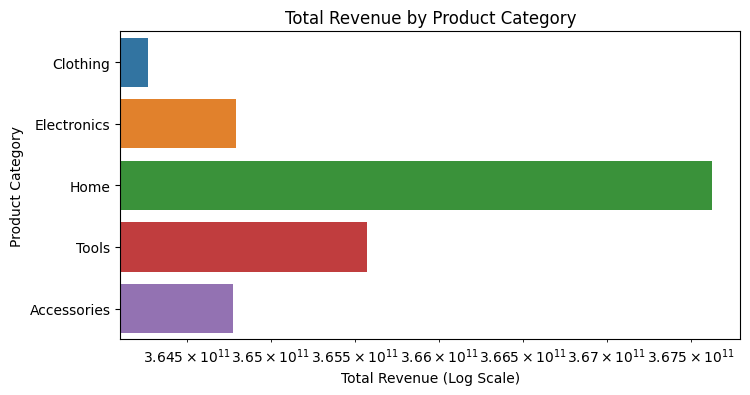

In [41]:
#visualization: bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x="total_revenue", y="category", data=result_df)
plt.xscale('log')
plt.xlabel("Total Revenue (Log Scale)")
plt.ylabel("Product Category")
plt.title("Total Revenue by Product Category")
plt.show()

2. Finding Users with the highest total spending by country

In [48]:
cur_time = time.time()
dfval = conn.execute("""
    SELECT u.country, u.user_id, u.user_name, SUM(t.amount) AS total_spending
    FROM transactions t
    JOIN users u ON t.user_id = u.user_id
    GROUP BY u.country, u.user_id, u.user_name
    ORDER BY total_spending DESC
""")
print(f"execution Time: {(time.time() - cur_time)}")
print(dfval.df())

execution Time: 3.1382761001586914
                country  user_id             user_name  total_spending
0      Papua New Guinea     1020  Alexander Harrington      5561300.86
1        American Samoa     1141      Nicholas Stevens      5555871.22
2              Paraguay     1940            Ryan Bowen      5552657.82
3              Djibouti     1097           Joanna Cobb      5552476.19
4               Jamaica     1158       Jessica Mendoza      5549751.61
..                  ...      ...                   ...             ...
995        South Africa     1248         Leonard Simon      5449612.79
996  Dominican Republic     1084               Mary Wu      5447087.44
997               Macao     1543        Crystal Miller      5446400.19
998              Guinea     1607     Sherri Washington      5445669.39
999           Guatemala     1687         James Johnson      5438982.83

[1000 rows x 4 columns]


3. Calculating the average Transaction amount per day between mar 1 23 00:00:00 till jun 30 23:59:59

In [30]:
from datetime import datetime

cur_time = time.time()
start_date = datetime(2023, 3, 1, 0, 0, 0)  # March 1, 2023, 00:00:00
end_date = datetime(2023, 6, 30, 23, 59, 59)  # June 30, 2023, 23:59:59


result_query = conn.execute(f"""
    SELECT transaction_date AS transaction_day, AVG(amount) AS avg_transaction_amount
    FROM transactions
    WHERE transaction_date BETWEEN '{start_date.strftime('%Y-%m-%d %H:%M:%S')}' AND '{end_date.strftime('%Y-%m-%d %H:%M:%S')}'
    GROUP BY transaction_date
""")


result_df = result_query.df()

print(f"Execution Time: {(time.time() - cur_time)} seconds")

print(result_df)


Execution Time: 20.50181746482849 seconds
              transaction_day  avg_transaction_amount
0         2023-05-01 15:30:32               53.293846
1         2023-05-26 06:18:18               52.541667
2         2023-06-28 00:49:04               60.828750
3         2023-04-20 16:20:51               57.165000
4         2023-04-07 13:32:33               44.558571
...                       ...                     ...
10496037  2023-03-30 02:01:51               31.110000
10496038  2023-03-12 15:36:00               41.470000
10496039  2023-04-15 15:01:44               25.590000
10496040  2023-03-16 09:07:13               63.220000
10496041  2023-06-05 22:11:09               32.490000

[10496042 rows x 2 columns]


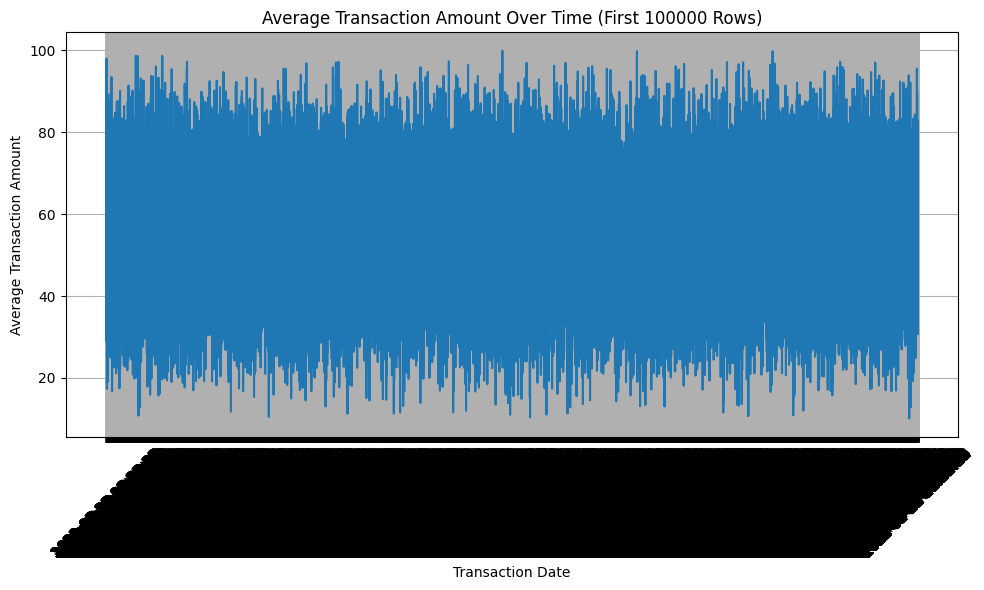

In [32]:
result_df =result_df.head(100000)
plt.figure(figsize=(10, 6))
plt.plot(result_df['transaction_day'], result_df['avg_transaction_amount'])
plt.xlabel("Transaction Date")
plt.ylabel("Average Transaction Amount")
plt.title("Average Transaction Amount Over Time (First 100000 Rows)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

4. Top Selling Product categories wuth average price 


In [57]:
conn.execute(" DESCRIBE users").df()

,column_name,column_type,null,key,default,extra
0,user_id,BIGINT,YES,NaN,NaN,NaN
1,user_name,VARCHAR,YES,NaN,NaN,NaN
2,email,VARCHAR,YES,NaN,NaN,NaN
3,date_of_birth,VARCHAR,YES,NaN,NaN,NaN
4,address,VARCHAR,YES,NaN,NaN,NaN
5,state,VARCHAR,YES,NaN,NaN,NaN
6,country,VARCHAR,YES,NaN,NaN,NaN


In [33]:
cur_time = time.time()


result_query = conn.execute("""
    SELECT p.category, COUNT(*) AS num_transactions, AVG(p.price) AS avg_price
    FROM transactions t
    JOIN products p ON t.product_id = p.product_id
    GROUP BY p.category
    ORDER BY num_transactions DESC
""")


result_df = result_query.df()


execution_time = time.time() - cur_time
print(f"Execution Time: {execution_time} seconds")

print(result_df)

Execution Time: 406.95651483535767 seconds
      category  num_transactions   avg_price
0         Home        6684073368  105.348279
1        Tools        6646594926  105.087792
2  Electronics        6632576248  105.035063
3  Accessories        6632211014  104.951051
4     Clothing        6623093991  104.938675


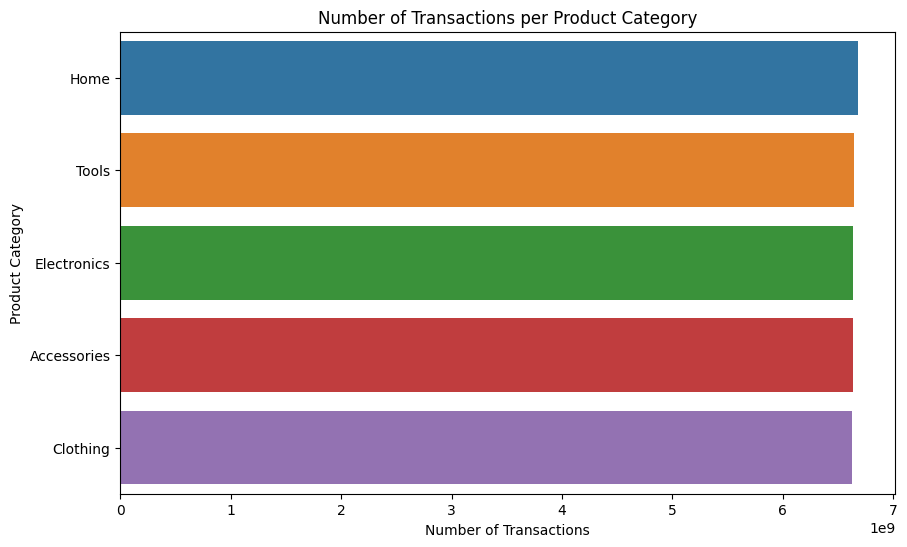

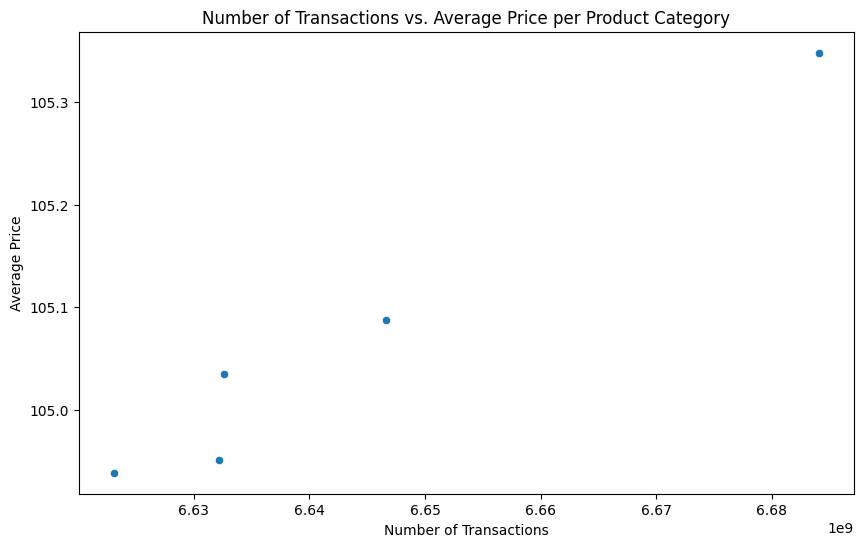

In [34]:
# Visualization 1: Bar chart for number of transactions per category
plt.figure(figsize=(10, 6))
sns.barplot(x="num_transactions", y="category", data=result_df)
plt.xlabel("Number of Transactions")
plt.ylabel("Product Category")
plt.title("Number of Transactions per Product Category")
plt.show()

# Visualization 2: Scatter plot for number of transactions vs. average price per category
plt.figure(figsize=(10, 6))
sns.scatterplot(x="num_transactions", y="avg_price", data=result_df)
plt.xlabel("Number of Transactions")
plt.ylabel("Average Price")
plt.title("Number of Transactions vs. Average Price per Product Category")
plt.show()

5. Grouping users by age and displaying it in ascending order of age 

In [35]:
cur_time = time.time()

# Execute the SQL query to calculate the age and user count
result_query = conn.execute("""
    SELECT DATE_PART('year', NOW()) - DATE_PART('year', CAST(date_of_birth AS TIMESTAMP)) AS age, COUNT(*) AS user_count
    FROM users
    GROUP BY age
    ORDER BY age
""")


result_df = result_query.df()

execution_time = time.time() - cur_time
print(f"Execution Time: {execution_time} seconds")
print(result_df)

Execution Time: 0.23099732398986816 seconds
    age  user_count
0    18       92280
1    19      159864
2    20      160764
3    21      160446
4    22      159855
..  ...         ...
59   77      159859
60   78      160052
61   79      160135
62   80      160216
63   81       67308

[64 rows x 2 columns]


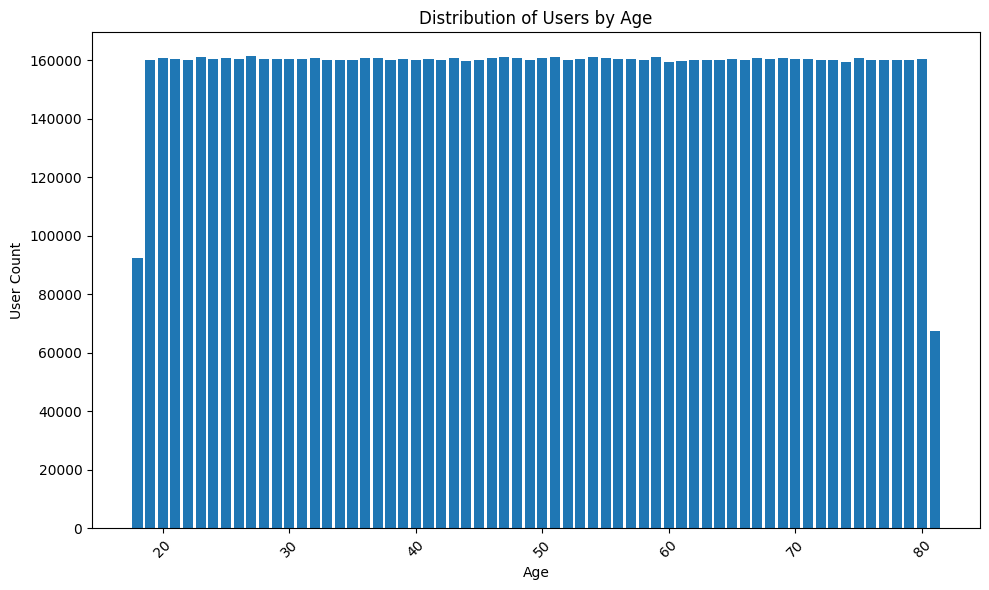

In [36]:
#visualization : histogrram
plt.figure(figsize=(10, 6))
plt.bar(result_df['age'], result_df['user_count'])
plt.xlabel("Age")
plt.ylabel("User Count")
plt.title("Distribution of Users by Age")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3>Optimizing the query</h3> 

We can see that querry  1. Calculating total revenue by category and 4. Top Selling Product categories wuth average price took substantiall longer time to execte. Lets try optimizing the query by appling certain optimization techniques


1. Applying indexing

In [6]:


# indexing the "category" in products
conn.execute("  DROP INDEX IF EXISTS idx_products_category ")

conn.execute("  DROP INDEX IF EXISTS idx_products_id ")



In [ ]:
conn.execute("CREATE INDEX idx_products_category ON products(category)")
conn.execute("CREATE INDEX idx_products_id ON products(product_id)")

In [39]:
conn.execute("  DROP INDEX IF EXISTS idx_transactions_product_id ")
conn.execute("CREATE INDEX idx_transactions_product_id ON transactions(product_id)")

Error: Invalid Error: bad allocation

1. total revenue by category

In [5]:
cur_time = time.time()
result_query = conn.execute("""
    SELECT p.category, SUM(t.amount) AS total_revenue
    FROM transactions t
    JOIN products p ON t.product_id = p.product_id
    GROUP BY p.category
""")

result_df = result_query.df()

print(f"Execution Time: {(time.time() - cur_time)} seconds")

print(result_df)

Execution Time: 352.1788866519928 seconds
      category  total_revenue
0         Home   3.676285e+11
1        Tools   3.655675e+11
2  Electronics   3.647923e+11
3  Accessories   3.647723e+11
4     Clothing   3.642730e+11


we see the exection time reduce from 385 to 348 seconds. Its a 9.6% reduction in unning time

2. top selling product categories with averrage price per category

In [14]:
cur_time = time.time()
result_query = conn.execute("""
    SELECT p.category, COUNT(*) AS num_transactions, AVG(p.price) AS avg_price
    FROM transactions t
    JOIN products p ON t.product_id = p.product_id
    GROUP BY p.category
    ORDER BY num_transactions DESC
""")
result_df = result_query.df()

execution_time = time.time() - cur_time
print(f"Execution Time: {execution_time} seconds")
print(result_df)

Execution Time: 368.6746642589569 seconds
      category  num_transactions   avg_price
0         Home        6684073368  105.348279
1        Tools        6646594926  105.087792
2  Electronics        6632576248  105.035063
3  Accessories        6632211014  104.951051
4     Clothing        6623093991  104.938675


We can see that the execution time reduced from 406 sec to 352 sec, That is a 13.3% percent reduction in running time

2. Window function

 1. Rank users based on their transaction amounts

we will have to use window functions here to achieve this, or else we might have to perform a self join on transactions to achive the same result which is resource intensive

In [7]:
cur_time = time.time()
result_query = conn.execute("""
    SELECT user_id, amount, RANK() OVER(ORDER BY amount DESC) AS rank
    FROM transactions
""")
result_df = result_query.df()

execution_time = time.time() - cur_time
print(f"Execution Time: {execution_time} seconds")
print(result_df)

In [4]:
conn.close()